In [1]:
import numpy as np
import ROOT as rt
import uproot

Welcome to JupyROOT 6.12/07


In [2]:
# background, data counts taken from Thong in Slack
h_a_bin_content = [2867.0, 1958.0, 1354.0, 943.0, 733.0, 544.0, 385.0, 283.0, 208.0, 159.0, 137.0, 
                   88.0, 87.0, 64.0, 40.0, 30.0, 36.0, 27.0, 15.0, 11.0, 14.0, 8.0, 4.0, 5.0, 5.0, 
                   8.0, 5.0, 3.0, 5.0, 2.0]
h_r_bin_content = [282266.0, 194922.0, 136354.0, 96062.0, 69503.0, 51147.0, 37484.0, 28032.0, 20982.0, 
                   15861.0, 12286.0, 9284.0, 7283.0, 5580.0, 4476.0, 3594.0, 2792.0, 2293.0, 1822.0, 
                   1469.0, 1188.0, 961.0, 797.0, 624.0, 540.0, 444.0, 334.0, 310.0, 247.0, 188.0]
bin_center_value = [1134.5267613891604, 1203.580284167481, 1272.6338069458018, 1341.6873297241227, 
                    1410.7408525024434, 1479.7943752807641, 1548.847898059085, 1617.9014208374058, 
                    1686.9549436157265, 1756.0084663940472, 1825.061989172368, 1894.1155119506889, 
                    1963.1690347290096, 2032.2225575073303, 2101.2760802856515, 2170.329603063972, 
                    2239.383125842293, 2308.4366486206136, 2377.4901713989343, 2446.5436941772555, 
                    2515.5972169555757, 2584.650739733897, 2653.7042625122176, 2722.7577852905383, 
                    2791.811308068859, 2860.8648308471797, 2929.9183536255005, 2998.971876403821, 
                    3068.0253991821423, 3137.0789219604626]
bin_width = bin_center_value[1]-bin_center_value[0]
bin_edges = [b-bin_width/2. for b in bin_center_value]+[bin_center_value[-1]+b-bin_width/2.]

n_bins = len(bin_edges)-1
max_bin = bin_edges[-1]
min_bin = bin_edges[0]

In [3]:
# dummy signal (not used)
PEAK = 3000
WIDTH = 300
SIGEVENTS = 300
signal = np.random.normal(PEAK, WIDTH, SIGEVENTS)

In [4]:
# prepare histograms and scale
background_hist = rt.TH1D('background','background', n_bins, min_bin, max_bin)
signal_hist = rt.TH1D('signal','signal', n_bins, min_bin, max_bin)
data_hist = rt.TH1D('data_obs','data_obs', n_bins, min_bin, max_bin)
for i, b in enumerate(h_r_bin_content):
    background_hist.SetBinContent(i+1, b)
for s in signal:
    signal_hist.Fill(s)
for i, d in enumerate(h_a_bin_content):
    data_hist.SetBinContent(i+1, d)
    
print("before scaling", background_hist.GetBinError(1))
print("before scaling", background_hist.GetBinContent(1))
data_hist.Sumw2()
signal_hist.Sumw2()
background_hist.Sumw2()
epsilon = data_hist.Integral()/background_hist.Integral()
background_hist.Scale(epsilon)
print("after scaling", background_hist.GetBinError(1))
print("after scaling", background_hist.GetBinContent(1))

('before scaling', 531.287116350472)
('before scaling', 282266.0)
('after scaling', 5.3863234705042675)
('after scaling', 2861.684264375079)


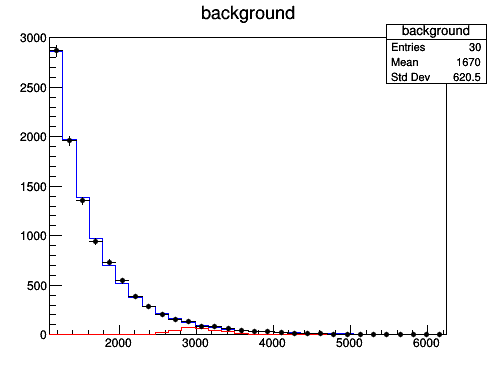

In [5]:
# plot background, signal, data
c = rt.TCanvas('c','c',500,400)
background_hist.SetLineColor(rt.kBlue)
background_hist.Draw('hist')

signal_hist.SetLineColor(rt.kRed)
signal_hist.Draw('histsame')

data_hist.SetLineColor(rt.kBlack)
data_hist.SetMarkerColor(rt.kBlack)
data_hist.SetMarkerStyle(20)
data_hist.SetMarkerSize(0.5)
data_hist.Draw('pezsame')
c.Draw()

In [6]:
# datacard template
# no background normalization uncertainty
# autoMCStats uncertainty
datacard = \
'''
imax 1
jmax 1
kmax *
---------------
shapes * * datacard_hist.root $PROCESS $PROCESS_$SYSTEMATIC
---------------
bin acc
observation {OBS}
------------------------------
bin             acc     acc
process         signal     background
process         0          1
rate            {SIGRATE}    {BKGRATE}
--------------------------------
#bgnorm   lnN    1.00       1.30
* autoMCStats 0 0 1
'''

In [7]:
# write histograms to root file 
datacard_hist = rt.TFile.Open('datacard_hist.root','recreate')
datacard_hist.cd()
background_hist.Write()
signal_hist.Write()
data_hist.Write()
datacard_hist.Close()

# write datacard
datacard_real = datacard.format(SIGRATE=signal_hist.Integral(), BKGRATE=background_hist.Integral(), OBS=data_hist.Integral())
print(datacard_real)
with open('datacard.txt','w') as f:
    f.write(datacard_real)


imax 1
jmax 1
kmax *
---------------
shapes * * datacard_hist.root $PROCESS $PROCESS_$SYSTEMATIC
---------------
bin acc
observation 10028.0
------------------------------
bin             acc     acc
process         signal     background
process         0          1
rate            300.0    10028.0
--------------------------------
#bgnorm   lnN    1.00       1.30
* autoMCStats 0 0 1



In [ ]:
# get obseverved goodness of fit test statistic (signal strength = 0)
!combine -M GoodnessOfFit --algo saturated --fixedSignalStrength 0 -d datacard.txt

# get expected goodness of fit test statistic distribution from frequentist toys
!combine -M GoodnessOfFit --algo saturated --fixedSignalStrength 0 -d datacard.txt -t 500 --toysFreq 

In [9]:
# open file
obs_gof_file = uproot.open('higgsCombineTest.GoodnessOfFit.mH120.root')
obs_gof = obs_gof_file['limit'].arrays('limit')['limit'][0]

exp_gof_file = uproot.open('higgsCombineTest.GoodnessOfFit.mH120.123456.root')
exp_gof = exp_gof_file['limit'].arrays('limit')['limit']

# # get p-value
n_extreme = len(exp_gof[exp_gof > obs_gof])
n_total = len(exp_gof)
pval = 1.*n_extreme/n_total
print 'p-value = %.2f'%pval

p-value = 0.81


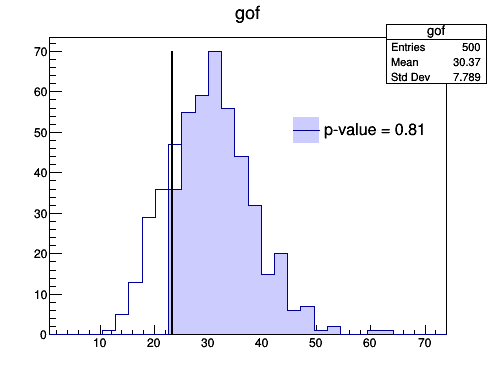

In [10]:
exp_gof_hist = rt.TH1D('gof','gof',30,min(exp_gof)-10, max(exp_gof)+10)
exp_gof_hist_gt = rt.TH1D('gof_gt','gof_gt',30,min(exp_gof)-10, max(exp_gof)+10)
for g in exp_gof: 
    exp_gof_hist.Fill(g)
    if g > obs_gof: 
        exp_gof_hist_gt.Fill(g)
d = rt.TCanvas('d','d',500,400)
tleg = rt.TLegend(0.58,0.6,0.88,0.7)
tleg.SetLineWidth(0)
exp_gof_hist.Draw('hist')
exp_gof_hist_gt.SetFillColor(rt.kBlue-10)
exp_gof_hist_gt.Draw('fhistsame')
line = rt.TLine(obs_gof,0,obs_gof,exp_gof_hist.GetMaximum())
line.SetLineWidth(2)
line.Draw()
tleg.AddEntry(exp_gof_hist_gt,'p-value = %.2f'%pval)
tleg.Draw()
d.Draw()